## Bandit起源

Bandit算法来源于历史悠久的赌博学。想象这样一个场景：一个赌，走进赌场，一眼看去是一排外表一摸一样的老虎机，但是呢？每个老虎机吐钱的概率不一样，他应该在每次如何选择老虎机才可以做到最大化收益？这就是多臂赌博机问题（Muti-arm Bandits，简称MAB）。一系列应对该问题的策略统称为Bandit算法。

![bandit](./imgs/bandit.png)


现实生活中我们也会遇到一系列类似的场景：

1. 新用户进入系统，如何得知他对哪个类别更感兴趣？
2. 有若干广告库物料，如何展示广告，才能获得最大收益？是一直展示收益最高的吗？
3. 玩家进入新游戏，哪个关卡是他最感兴趣的，如何合理排序？

解决这类问题最好的方法就是去试，但也不是随便试，而是有策略的试，通过多次实验摸透每个老虎机背后的赢钱规律（概率分布）。

## 相关概念

##### 累计遗憾

Bandit算法的思想是，看看每次选择会带来多少遗憾，累计遗憾越少越好。

$R_{T}=\sum^{T}_{i=1}(w_{opt}-w_{B(i)})=Tw^{*} - \sum^{T}_{i=1}w_{B(i)}$

$w_{opt}$是每次最优选择得到的收益，$w_{B(i)}$是每次实际选择得到的收益，二者的差就是遗憾的量化。进行T次选择之后，就获得累计遗憾$R_{T}$。

In [18]:
import math
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

## 场景

有5个老虎机，每个老虎机背后有一个真实奖励概率。问：如何在有限的操作次数下，更快的找到具有最大收益的老虎机，是总收益最高？

##### 随机选择

随机试若干次，计算每个臂的平均收益，一直选均值最大的那个臂。这个算法是在实际生活中最常采用。（这里为了避免歧义，设定每台老虎机一个臂。）

In [19]:
def random_select(k, n):
    """ k个老虎机，总共进行n次操作 """
    # 各老虎机期望奖励
    expect_reward = [0] * k
    # 各老虎机操作次数
    operation = [0] * k
    # 总奖励
    total_reward = 0
    
    for i in range(n):
        # 随机选择一个摇臂
        arm = np.random.choice(5, size=1)[0]
        
        # 反馈的奖励数据
        arm_reward = np.random.binomial(1, real_reward[arm], size=1)[0]
        
        # 更新期望奖励
        expect_reward[arm] = (expect_reward[arm] * operation[arm] + arm_reward) / (operation[arm] + 1)
        
        # 更新摇臂次数
        operation[arm] += 1
        
        # 更新累计奖励
        total_reward += arm_reward
    
    return total_reward, expect_reward, operation

# 随机生成真实奖励
real_reward = [round(random.uniform(0, 1), 1) for i in range(5)] 
total_reward, expect_reward, operation = random_select(5, 1000)

# 查看总收益与操作次数
print('total_reward: ', total_reward)
res_df = pd.DataFrame({
    '真实奖励': real_reward[:len(operation)],
    '期望奖励': expect_reward,
    '操作次数': operation,
    '操作占比': [i*1.0/sum(operation) for i in operation]
})
res_df

total_reward:  794


,真实奖励,期望奖励,操作次数,操作占比
0,0.9,0.911458,192,0.192
1,0.5,0.530612,196,0.196
2,0.6,0.568889,225,0.225
3,1.0,1.000000,201,0.201
4,1.0,1.000000,186,0.186


##### Epsilon-Greedy

Epsilon贪婪算法原理

1. 在(0, 1)之间选择一个数，名为epsilon。
2. 每次以epsilon概率（探索率）随机选择一个臂，以1-epsilon概率选择平均收益最大的臂。

In [20]:
def epsilon_greedy(k, n, epsilon=0.2):
    # 各老虎机期望奖励
    expect_reward = [0] * k
    # 各老虎机操作次数
    operation = [0] * k
    # 总奖励
    total_reward = 0
    
    for i in range(n):
        # 产生0-1之间的随机数
        r = np.random.uniform(size=1)[0]
        if r > epsilon:
            best_arm = expect_reward.index(max(expect_reward))
        else:
            best_arm = np.random.choice(k, size=1)[0]
        
        # 反馈的奖励数据
        arm_reward = np.random.binomial(1, real_reward[best_arm], size=1)[0]
        
        # 更新期望奖励
        expect_reward[best_arm] = (expect_reward[best_arm] * operation[best_arm] + arm_reward) / (operation[best_arm] + 1)
        
        # 更新摇臂次数
        operation[best_arm] += 1
        
        # 更新累计奖励
        total_reward += arm_reward
        
    return total_reward, expect_reward, operation

total_reward, expect_reward, operation = epsilon_greedy(5, 1000)

print('total_reward: ', total_reward)
res_df = pd.DataFrame({
    '真实奖励': real_reward[:len(operation)],
    '期望奖励': expect_reward,
    '操作次数': operation,
    '操作占比': [i*1.0/sum(operation) for i in operation]
})
res_df

total_reward:  963


,真实奖励,期望奖励,操作次数,操作占比
0,0.9,0.897959,49,0.049
1,0.5,0.545455,33,0.033
2,0.6,0.604651,43,0.043
3,1.0,1.000000,822,0.822
4,1.0,1.000000,53,0.053


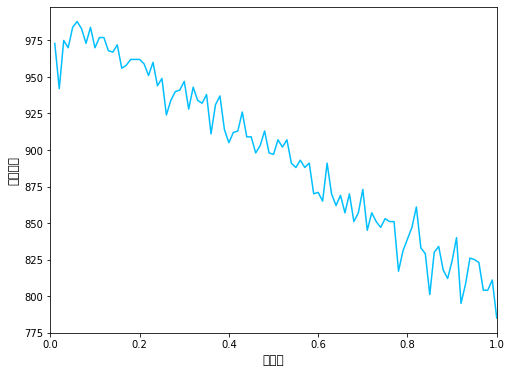

In [21]:
# 累计奖励与探索率的关系
epsilon_list = np.arange(0.01, 1.01, 0.01)

total_reward_list = [epsilon_greedy(5, 1000, epsilon=i)[0] for i in epsilon_list]

plt.figure(figsize=(8,6))
plt.plot(epsilon_list, total_reward_list, c='deepskyblue')
plt.xlabel('探索率', fontsize=12)
plt.ylabel('累积奖励', fontsize=12)
plt.xlim(0, 1)
plt.show()

可以看到，累计奖励随着探索率的增加而降低。

##### Boltzmann

Boltzmann的原理：不根据当前摇臂的期望收益来对摇臂分配试验次数，而根据“有多大可能最佳的摇臂”来分配。

玻尔兹曼探索策略以归一化后的概率操作第i个摇臂，它以玻尔兹曼分布来进行摇臂的选择。

$p_{i} = \frac{exp(\frac{E(R_{i})}{τ}}{\sum^{K}_{j=1}exp(\frac{E(R_{j})}{τ}}$

K表示摇臂的个数，$E(R_{i})$表示奖励期望的估计，pi，i=1,2,...K表示第i个摇臂被选择的概率；
τ表示探索和利用的程度(探索率)，接近于0趋于“仅利用”，接近于无穷时趋于“仅探索”。

In [22]:
sigma = 0.2

def boltzmann(k, n, sigma):
    # 各老虎机期望奖励
    expect_reward = [0] * k
    # 各老虎机操作次数
    operation = [0] * k
    # 总奖励
    total_reward = 0
    
    for i in range(n):
        
        reward_prob = np.exp(np.array(expect_reward)/ sigma) / np.exp(np.array(expect_reward)/sigma).sum()
        
        # 根据奖励的分布选取摇臂
        best_arm = np.random.choice(k, size=1, p=reward_prob)[0]
        
        # 反馈的奖励数据
        arm_reward = np.random.binomial(1, real_reward[best_arm], size=1)[0]
        
        # 更新期望奖励
        expect_reward[best_arm] = (expect_reward[best_arm] * operation[best_arm] + arm_reward) / (operation[best_arm] + 1)
        
        # 更新摇臂次数
        operation[best_arm] += 1
    
        # 更新累计奖励
        total_reward += arm_reward
    
    return total_reward, expect_reward, operation

total_reward, expect_reward, operation = boltzmann(5, 1000, sigma)

print('total_reward: ', total_reward)
res_df = pd.DataFrame({
    '真实奖励': real_reward[:len(operation)],
    '期望奖励': expect_reward,
    '操作次数': operation,
    '操作占比': [i*1.0/sum(operation) for i in operation]
})
res_df

total_reward:  972


,真实奖励,期望奖励,操作次数,操作占比
0,0.9,0.926471,272,0.272
1,0.5,0.000000,3,0.003
2,0.6,0.000000,5,0.005
3,1.0,1.000000,408,0.408
4,1.0,1.000000,312,0.312


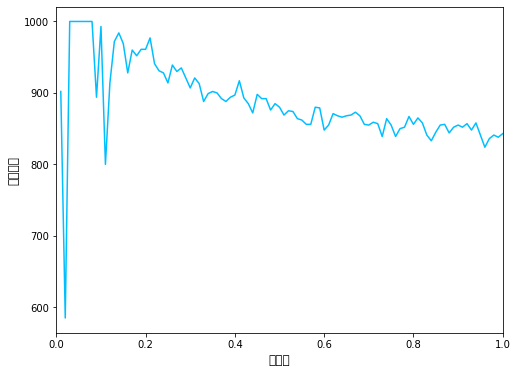

In [23]:
# 累计奖励与探索率的关系
epsilon_list = np.arange(0.01, 1.01, 0.01)

total_reward_list = [boltzmann(5, 1000, sigma=i)[0] for i in epsilon_list]

plt.figure(figsize=(8,6))
plt.plot(epsilon_list, total_reward_list, c='deepskyblue')
plt.xlabel('探索率', fontsize=12)
plt.ylabel('累积奖励', fontsize=12)
plt.xlim(0, 1)
plt.show()

##### UCB

置信区间上界（Upper Confidence Bound，UCB），为每个臂评分，选择评分最高的候选臂。然后观察用户反馈，更新候选臂。

$x_{j}^{-}(t) + \sqrt{\frac{2lnt}{T_{j,t}}}$

t是目前的总选择次数，$x_{j}^{-}$是每个臂的平均收益，$T_{j,t}$是j臂的选择次数。由公式可知，一个候选臂被选择次数$T_{j,t}$越小，它的价值越大，排序越靠前。（从公式上可以看出，除了臂本身的平均收益之外，增加了一个选择次数的维度，相同次数下，选择次数越少，值越大。）

In [24]:
def ucb(k, n):
    """ k个老虎机，总共进行n次操作 """
    # 各老虎机期望奖励
    expect_reward = np.array([0.0] * k)
    # 各老虎机操作次数
    operation = np.array([0] * k)
    # 总奖励
    total_reward = 0.0
    
    for i in range(n):
        total_operation = np.sum(operation)
        ucb_q_values = expect_reward + np.sqrt(np.reciprocal(operation+0.001)*2*math.log(total_operation+1.0))
        best_arm_value = np.max(ucb_q_values)
        best_arms = np.argwhere(ucb_q_values == best_arm_value).flatten()
        arm = best_arms[np.random.randint(0, len(best_arms))]
        
        # 反馈的奖励数据
        arm_reward = np.random.binomial(1, real_reward[arm], size=1)[0]
        
        # 更新期望奖励
        expect_reward[arm] = (expect_reward[arm] * operation[arm] + arm_reward)*1.0 / (operation[arm] + 1)
        
        # 更新摇臂次数
        operation[arm] += 1
        
        # 更新累计奖励
        total_reward += arm_reward
    
    return total_reward, expect_reward, operation

total_reward, expect_reward, operation = ucb(5, 1000)

print('total_reward: ', total_reward)
res_df = pd.DataFrame({
    '真实奖励': real_reward[:len(operation)],
    '期望奖励': expect_reward,
    '操作次数': operation,
    '操作占比': [i*1.0/sum(operation) for i in operation]
})
res_df

total_reward:  949.0


,真实奖励,期望奖励,操作次数,操作占比
0,0.9,0.866667,135,0.135
1,0.5,0.515152,33,0.033
2,0.6,0.645833,48,0.048
3,1.0,1.000000,392,0.392
4,1.0,1.000000,392,0.392


##### Thompson sampling

汤普森采样算法原理

假设每个臂背后的概率分布是Beta分布。
每次选择，每个臂都会出一个随机数，然后按随机数排序，输出最大随机数的臂对应的物品。
代入到推荐场景中。Beta分布有两个参数，a参数代表用户点击次数，b参数代表用户没有点击次数，然后进行汤普森采样。
1. 取出每一个候选臂对应的参数a和b。
2. 每个候选臂根据Beta(a,b)产生一个随机数。
3. 按随机数排序，输出最大值对应的候选臂。
4. 根据用户反馈，用户点击则a+1，否则b+1。

In [25]:
def thompson_sample(k, n):
    """ k个老虎机，总共进行n次操作 """
    # 各老虎机期望奖励
    expect_reward = np.array([0.0] * k)
    # 各老虎机操作次数
    operation = np.array([0] * k)
    success = np.array([0] * k)
    failure = np.array([0] * k)
    # 总奖励
    total_reward = 0.0
    
    for i in range(n):
        sample_means = np.zeros(len(operation))
        for j in range(k):
            sample_means[j] = np.random.beta(success[j]+1, failure[j]+1)
        best_arm_value = np.max(sample_means)
        best_arms = np.argwhere(sample_means == best_arm_value).flatten()
        arm = best_arms[np.random.randint(0, len(best_arms))]
        
        # 反馈的奖励数据
        arm_reward = np.random.binomial(1, real_reward[arm], size=1)[0]
        
        # 更新期望奖励
        expect_reward[arm] = (expect_reward[arm] * operation[arm] + arm_reward)*1.0 / (operation[arm] + 1)
        
        # 更新摇臂次数
        operation[arm] += 1
        
        success[arm] += arm_reward
        
        failure[arm] += (1 - arm_reward)
        
        # 更新累计奖励
        total_reward += arm_reward
        
    return total_reward, expect_reward, operation

total_reward, expect_reward, operation = thompson_sample(5, 1000)
res_df = pd.DataFrame({
    '真实奖励': real_reward,
    '期望奖励': expect_reward,
    '操作次数': operation,
    '操作占比': [i*1.0/sum(operation) for i in operation]
})
res_df

,真实奖励,期望奖励,操作次数,操作占比
0,0.9,0.00,1,0.001
1,0.5,0.75,4,0.004
2,0.6,0.00,1,0.001
3,1.0,1.00,671,0.671
4,1.0,1.00,323,0.323


##### 各策略稳定性和随机奖励对比

四种策略各模拟100次，绘制直方图和折线图，查看哪种策略收益最高、最稳定。

random_select:  247.4 1.0
epsilon_greedy01:  376.44 1.5215844785772028
epsilon_greedy02:  365.09 1.4757073565076797
epsilon_greedy03:  350.34 1.4160873080032335
boltzmann01:  339.57 1.372554567502021
boltzmann02:  358.6 1.4494745351657237
boltzmann03:  334.47 1.3519401778496363
ucb:  351.51 1.4208164915117218
thompson_sample:  393.89 1.5921180274858528


([<matplotlib.axis.XTick at 0x19f3b3f4c18>,
 [Text(0, 0, 'random_select'),
  Text(1, 0, 'epsilon_greedy01'),
  Text(2, 0, 'epsilon_greedy02'),
  Text(3, 0, 'epsilon_greedy03'),
  Text(4, 0, 'boltzmann01'),
  Text(5, 0, 'boltzmann02'),
  Text(6, 0, 'boltzmann03'),
  Text(7, 0, 'ucb'),
  Text(8, 0, 'thompson_sample')])

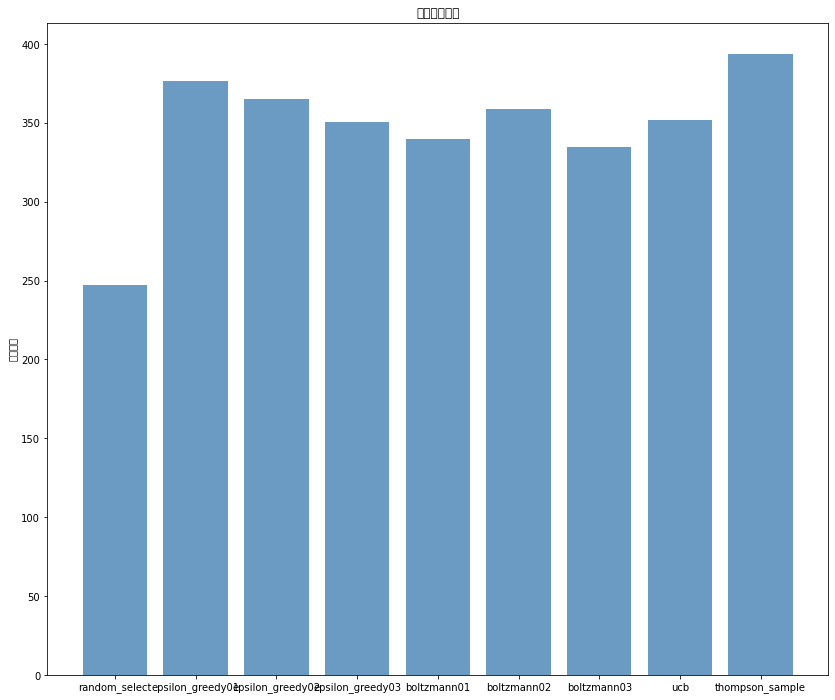

In [26]:
plt.figure(figsize=(14, 12))

# 老虎机个数、选择次数
k = 5
N = 400

# 模拟
real_reward = [round(random.uniform(0, 1), 1) for i in range(k)] 

random_select_simulate = [random_select(k, N)[0] for i in range(100)]
epsilon_greedy_simulate01 = [epsilon_greedy(k, N, epsilon=0.1)[0] for i in range(100)]
epsilon_greedy_simulate02 = [epsilon_greedy(k, N, epsilon=0.2)[0] for i in range(100)]
epsilon_greedy_simulate03 = [epsilon_greedy(k, N, epsilon=0.3)[0] for i in range(100)]
boltzmann_simulate01 = [boltzmann(k, N, sigma=0.1)[0] for i in range(100)]
boltzmann_simulate02 = [boltzmann(k, N, sigma=0.2)[0] for i in range(100)]
boltzmann_simulate03 = [boltzmann(k, N, sigma=0.3)[0] for i in range(100)]
ucb_simulate = [ucb(k, N)[0] for i in range(100)]
thompson_sample_simulate = [thompson_sample(k, N)[0] for i in range(100)]

# 平均累计奖励
print('random_select: ', np.mean(random_select_simulate), np.mean(random_select_simulate)/np.mean(random_select_simulate))
print('epsilon_greedy01: ', np.mean(epsilon_greedy_simulate01), np.mean(epsilon_greedy_simulate01)/np.mean(random_select_simulate))
print('epsilon_greedy02: ', np.mean(epsilon_greedy_simulate02), np.mean(epsilon_greedy_simulate02)/np.mean(random_select_simulate))
print('epsilon_greedy03: ', np.mean(epsilon_greedy_simulate03), np.mean(epsilon_greedy_simulate03)/np.mean(random_select_simulate))
print('boltzmann01: ', np.mean(boltzmann_simulate01), np.mean(boltzmann_simulate01)/np.mean(random_select_simulate))
print('boltzmann02: ', np.mean(boltzmann_simulate02), np.mean(boltzmann_simulate02)/np.mean(random_select_simulate))
print('boltzmann03: ', np.mean(boltzmann_simulate03), np.mean(boltzmann_simulate03)/np.mean(random_select_simulate))
print('ucb: ', np.mean(ucb_simulate), np.mean(ucb_simulate)/np.mean(random_select_simulate))
print('thompson_sample: ', np.mean(thompson_sample_simulate), np.mean(thompson_sample_simulate)/np.mean(random_select_simulate))

simulate_list = [
    np.mean(random_select_simulate),
    np.mean(epsilon_greedy_simulate01),
    np.mean(epsilon_greedy_simulate02),
    np.mean(epsilon_greedy_simulate03),
    np.mean(boltzmann_simulate01),
    np.mean(boltzmann_simulate02),
    np.mean(boltzmann_simulate03),
    np.mean(ucb_simulate),
    np.mean(thompson_sample_simulate)
]
plt.bar(range(len(simulate_list)), simulate_list, align='center', color='steelblue', alpha=0.8)
plt.ylabel('累计奖励')
plt.title('平均累计奖励')
plt.xticks(range(len(simulate_list)), ['random_select',
                      'epsilon_greedy01',
                      'epsilon_greedy02',
                      'epsilon_greedy03',
                      'boltzmann01',
                      'boltzmann02',
                      'boltzmann03',
                      'ucb',
                      'thompson_sample'])

##### 各策略稳定性对比

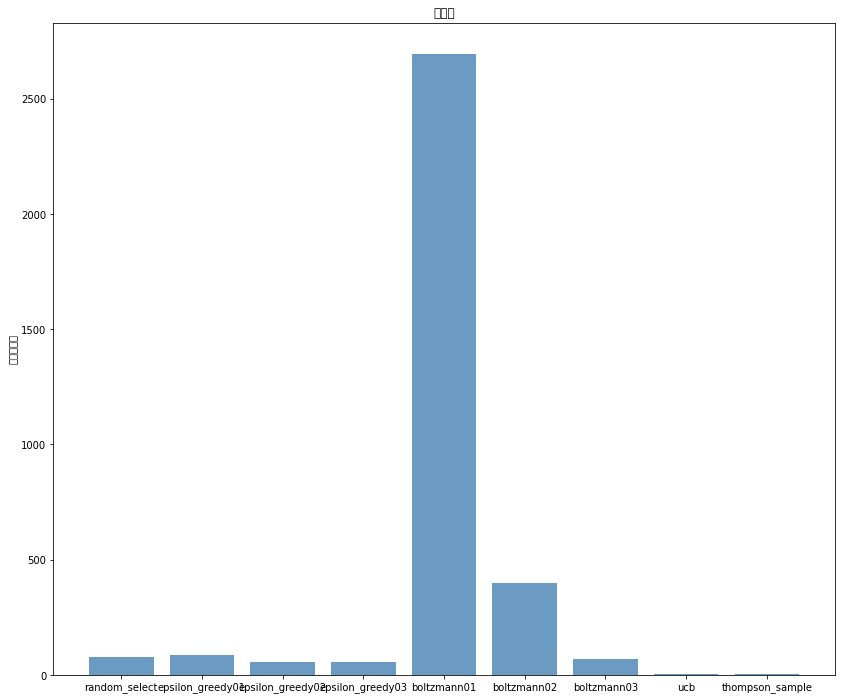

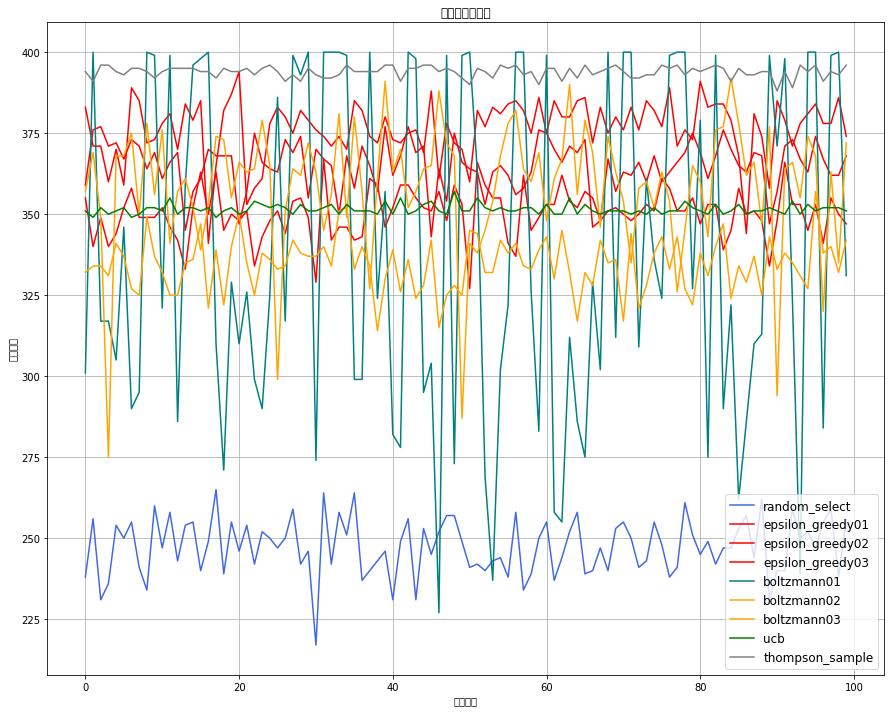

In [27]:
# 柱状图对比策略稳定性
plt.figure(figsize=(14, 12))
simulate_var_list = [
    np.var(random_select_simulate),
    np.var(epsilon_greedy_simulate01),
    np.var(epsilon_greedy_simulate02),
    np.var(epsilon_greedy_simulate03),
    np.var(boltzmann_simulate01),
    np.var(boltzmann_simulate02),
    np.var(boltzmann_simulate03),
    np.var(ucb_simulate),
    np.var(thompson_sample_simulate)
]
plt.bar(range(len(simulate_list)), simulate_var_list, align='center', color='steelblue', alpha=0.8)
plt.ylabel('稳定性对比')
plt.title('稳定性')
plt.xticks(range(len(simulate_list)), ['random_select',
                      'epsilon_greedy01',
                      'epsilon_greedy02',
                      'epsilon_greedy03',
                      'boltzmann01',
                      'boltzmann02',
                      'boltzmann03',
                      'ucb',
                      'thompson_sample'])

# 折现图对比策略稳定性
plt.figure(figsize=(15, 12))

plt.title('策略稳定性对比')
plt.plot(range(100), random_select_simulate, c='royalblue', label='random_select')
plt.plot(range(100), epsilon_greedy_simulate01, c='red', label='epsilon_greedy01')
plt.plot(range(100), epsilon_greedy_simulate02, c='red', label='epsilon_greedy02')
plt.plot(range(100), epsilon_greedy_simulate03, c='red', label='epsilon_greedy03')
plt.plot(range(100), boltzmann_simulate01, c='teal', label='boltzmann01')
plt.plot(range(100), boltzmann_simulate02, c='orange', label='boltzmann02')
plt.plot(range(100), boltzmann_simulate03, c='orange', label='boltzmann03')
plt.plot(range(100), ucb_simulate, c='g', label='ucb')
plt.plot(range(100), thompson_sample_simulate, c='gray', label='thompson_sample')

plt.xlabel('模拟次数')
plt.ylabel('累计奖励')
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)
plt.show()

从图中可以看到，随机选择策略的累计奖励最低，其他四种策略奖励相差不大；其中thompson_sample累计奖励最高且稳定性好，其次ucb、epsilon_greedy表现也很不错。